# LXM

> LXM: Better Splittable Pseudorandom Number Generators (and Almost as Fast)
> - Paper: https://dl.acm.org/doi/abs/10.1145/3485525
> - Video: https://youtu.be/OXurCqln_qc


En el 2021 Guy Steele y Sebastiano Vigna presentaron un generador de números pseudo aleatorios (PRNG) que se construye a partir de otro PRNG en donde colaboro Guy Steele llamado SplitMix. La principal propiedad de ambos PRNGs es que estos generadores son partibles (_splittable_), es decir, se pueden dividir en dos nuevos generadores estadísticamente independientes, lo cual es de gran utilidad en ambientes concurrentes.

LXM se basa en combinar tres ideas: un generador lineal congruente (la L), un generador basado en XORs (la X) y el resultado de la combinación de esos dos generadores utilizarlo como input en una función mezcladora (la M).

En este trabajo nos centraremos específicamente en la parte práctica del algoritmo y lo re-implementaremos en nuestro propio código, evitando hablar tanto de la concurrencia como de la propiedad partible del algoritmo (lo cual consiste de la mayoría del paper de Guy Steele y Sebastiano Vigna). Las ideas principales surgen de la sección 2 del paper (`THE LXM GENERATION ALGORITHM`)

## Ejercicio 1

Sobre el generador de números al azar propuesto en el paper asignado, se pide:
- Implementarlo en función de lo especificado en el documento.
- Modificarlo (si aplica) para obtener números al azar entre 0 y 1
- Realizar los gráficos que se consideren adecuados para mostrar las distribuciones de números al azar
generados en ambos casos (explicar que se busca interpretar con cada uno)

In [ ]:
def LXM(seed):  
    def L(s, m=2891336453, a=1310709051, x0=0, x1=1, k=64):
        """Full-Period Linear Congruental PRNG with Power-of-Two Modulus
        
        - El multiplicador `m` debe cumplir `(m mod 8) = 5`
        - El adicionador `a` debe ser un entero impar
        - K determina el tamaño en bits del número a generar (32 o 64)
        """
        return (m * s + a) % (2**k)
    def X(x0 = 2521368290, x1 = 756546341, k = 32):
        """F2-linear PRNG: xoroshiro128_1.10"""
        rotate_left = lambda n, d: (n << d)|(n >> (k - d))
        
        q0 = x0, q1 = x1;
        q1 ^= q0;
        q0 = rotate_left(q0, 24);
        q0 = q0 ^ q1 ^ (q1 << 16);
        q1 = rotate_left(q1, 37);
        x0 = q0, x1 = q1;
        pass
    def M():
        pass
    return L(10)

print(LXM(1))

30224073581


In [ ]:
def LXM(s, m=2891336453, a=1310709051, x0=0, x1=1, k=64):
    while True:
        # Combining operation
        z = s + x0
        # Mixing function (lea64)
        z = (z ^ (z >> 32)) * 0xdaba0b6eb09322e3
        z = (z ^ (z >> 32)) * 0xdaba0b6eb09322e3
        z = (z ^ (z >> 32))
        # Update the LCG subgenerator
        s = m * s + a
        # Update the XBG subgenerator (xoroshiro128v1_0)
        rotate_left = lambda n, d: (n << d) | (n >> (k - d))
        q0 = x0; q1 = x1
        q1 ^= q0
        q0 = rotate_left(q0, 24)
        q0 = q0 ^ q1 ^ (q1 << 16)
        q1 = rotate_left(q1, 37)
        x0 = q0; x1 = q1
        # Return result
        yield z

g = LXM(1)
print(next(g))
print(next(g))
print(next(g))
print(next(g))
print(next(g))
print(next(g))
print(next(g))
print(next(g))
print(next(g))

248406675341966701360907727913358551756
1043832433722000467235368176024546196021367528663
3020261450004936141101267192058813145176361943279573799389
9033676731583918517068380096377077345506981372434378294860272417272
67500185099281986455451641035352444674986214491684867884850769985016252943372
5882494877708633463023646289678164296219375519137283545033758419402844505907934953211233
798669224101284646133860533884163046913752630062107202070471602736807738016721059661510617830766726
109739831288922926578624437103748331218967009648559143901614391904372269482973656613224726899285744516575976873
15082452711270142419493206526630503989545991098204497231338686331533007945066291614306666583317779468818673594300501390094


In [10]:
import numpy as np
def rot_left(num, bits, word_size): 
    s = ""
    mask = 0
    if(num.bit_length() > 0): 
        for i in range(num.bit_length()): 
            s+=str(1) 
        mask = int(s, 2) 
    numh = (num << bits) 
    numh &= mask 
    numl = (num >> abs(min(num.bit_length(),word_size) - bits)) 
    result = (numh | numl) 
    return result

def LXMv2(s, m=2891336453, a=1310709051, x0=0, x1=1, k=64):
    while True:
        # Combining operation
        z = s + x0
        # Mixing function (lea64)
        z = (z ^ (z >> 32)) * 0xdaba0b6eb09322e3
        z = (z ^ (z >> 32)) * 0xdaba0b6eb09322e3
        z = (z ^ (z >> 32))
        z &= np.iinfo(np.uint64).max
        # Update the LCG subgenerator
        s = (m * s + a) % 2**k
        # Update the XBG subgenerator (xoroshiro128v1_0)
        #rotate_left = lambda n, d: (n << d) | (n >> (k - d))
        q0 = x0; q1 = x1
        q1 ^= q0
        q0 = rot_left(q0, 24, k)
        q0 = q0 ^ q1 ^ (q1 << 16)
        q1 = rot_left(q1, 37, k)
        x0 = q0; x1 = q1
        # Return result
        yield z, z/2**64
        
g = LXMv2(1)
print(next(g))
print(next(g))
print(next(g))
print(next(g))
print(next(g))
print(next(g))
print(next(g))
print(next(g))
print(next(g))

(2532866878614891212, 0.13730698862054216)
(7794654220077489367, 0.42254905195906595)
(15174648161747453451, 0.8226193251834878)
(14990250312348902691, 0.8126230977375096)
(12687714732829812766, 0.6878023938605212)
(2733716746656947430, 0.14819508178427337)
(10972405584109764748, 0.5948152985841944)
(8273826566687985741, 0.4485250369185698)
(4523919966533558551, 0.24524219279331175)


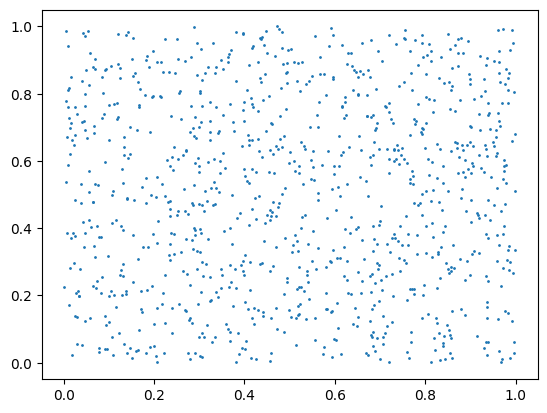

In [11]:
import matplotlib.pyplot as plt
x = []; y = []
for i in range(1000):
    z, zf = next(g)
    x.append(zf)
    z, zf = next(g)
    y.append(zf)
plt.scatter(x,y,1)

## Ejercicio 2

Para los generadores implementados en el ejercicio 1:
- Proponer, y realizar, al menos 3 tests para evaluar su comportamiento.
- Evaluar e interpretar los resultados de cada test para distintos tamaños de muestras.

## Ejercicio 3

Utilizando el generador implementado en el ejercicio 1:
- Implementar un método para generar variables aleatorias con distribución normal con media 10 y desvío 2.
- Graficar la distribución que siguen los números pseudoaleatorios generados.
- Realizar, al menos 2 tests, de los explicados en la materia, para verificar si los números generados siguen la distribución pedida (evalué los resultados para distintos tamaños de muestra).

## Ejercicio 4

La llegada de vehículos a un estacionamiento sigue un proceso de Poisson de tasa λ vehículos/hora. En el trabajo práctico se incluye un archivo con números pseudoaleatorios que representan los tiempos entre arribos de dichos vehículos.
- Realice una estimación de la tasa de arribos y proponga un test para evaluar si los números pseudoaleatorios provistos siguen la distribución esperada.
- Utilizando el GCL implementado en el Ejercicio 1 simular la llegada de vehículos durante un mes. Graficar la cantidad de arribos en función del tiempo.
- Generar 1000 realizaciones del proceso de Poisson para estimar las siguientes probabilidades:
  1. Probabilidad que el primer vehículo arribe antes de los 10 minutos.
  2. Probabilidad que el undécimo vehículo arribe después de los 60 minutos.
  3. Probabilidad que arriben al menos 750 vehículos antes de las 72 horas.

Comparar con los valores teóricos.

## Ejercicio 5

A partir del generador de número al azar implementado en el ejercicio 1, y del dataset provisto, obtenido del sitio de datos abiertos del Gobierno de la Ciudad de Buenos Aires (data.buenosaires.gob.ar), el cual contiene información geográfica de barrios de la Ciudad de Buenos Aires, se pide:
- Proponer e implementar un método que permita generar coordenadas (latitud y longitud) distribuidas de forma uniforme en cada uno de los barrios.
- Graficar los puntos generados en el mapa

## Ejercicio 6
Comparar los resultados obtenidos en los ejercicios 1 a 5 utilizando el generador de números al azar propuesto en el paper asignado, con los resultados que se obtendrían con un Generador Congruencial Lineal de módulo 232, multiplicador 1013904223, incremento de 1664525 y semilla igual a la parte entera del promedio de los números de padrón de los integrantes del grupo.